In [1]:
import casadi as ca
import casadi.tools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'casadi'

# Robot kinematics

States:

- $\vec{p} \in R^2$ position of robot
- $\theta$ angle of robot [rad]

Inputs:

- $v$ translational velocity [m/s]
- $\omega$ rotational velocity [rad/s]

State equations:

$$\dot{p} = v \; [\cos{\theta}, \sin{\theta}]$$
$$\dot{\theta} = \omega$$

In [2]:
# State vector
x = ca.tools.struct_symMX([ca.tools.entry("p", shape=2), "𝜃"])

# Input vector
u = ca.tools.struct_symMX(["v", "𝜔"])

# State equations
dxdt = ca.tools.struct_MX(x)

dp_x = u["v"] * ca.cos(x["𝜃"])
dp_y = u["v"] * ca.sin(x["𝜃"])
d𝜃 = u["𝜔"]

dxdt["p"] = ca.vertcat(dp_x, dp_y)
dxdt["𝜃"] = d𝜃
                               
# ODE Right-hand side
rhs = dxdt
f = ca.Function('f', [x, u], [rhs], ['x', 'u'], ['dx/dt'])

f

Function(f:(x[3],u[2])->(dx/dt[3]) MXFunction)

# Integration

Now we have dynamics described through CasADi symbols and functions.
We can now introduce integrators for e.g. simulation.

Here we introduce an integrator to simulate a single sample -- this is to formulate discrete dynamics from our continous dynamics.

So we move from our formulation of:

$$
\dot{x} = f(t,x,u)
$$

to:

$$
x[k+1] = F(x[k], u[k])
$$

where $F$ is the integration of $f$ over one sample period of $\Delta t$.

The integration can be done in many different ways; CasADi includes an interface to common integrators from *SUNDIALS*, but it is also easy (and sometimes very beneficial) to built e.g. a RK4 integrator, which minimizes additional overhead.

In [3]:
#dt = 1 # [s], 10 Hz sampling
dt = ca.MX.sym("dt")

# RK4
k1 = f(x, u)
k2 = f(x + dt / 2.0 * k1, u)
k3 = f(x + dt / 2.0 * k2, u)
k4 = f(x + dt * k3, u)
xf = x + dt / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)

# Single step time propagation
F_RK4 = ca.Function("F_RK4", [x, u, dt], [xf], ['x[k]', 'u[k]', "dt"], ['x[k+1]'])

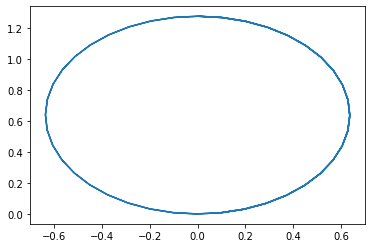

In [4]:
# IVP
simulator = F_RK4.mapaccum(100)
res = simulator([0, 0, 0], [1, 1.57], 0.1) # dt = 1

sol_traj = pd.DataFrame(res.toarray().T, columns=['x', 'y', '𝜃'])

plt.plot(sol_traj["x"], sol_traj["y"])

# Optimal control formulations

There are two ways of posing optimization problems in CasADi; either 'bare-metal' using pure CasADi symbolics or with a higher-level interface which significantly eases problem formulation + adds helpful debugging features.

In [5]:
opti = ca.Opti()

# Optimization horizon
N = 50

# Decision variables for states and inputs
X = opti.variable(x.size, N+1)

p_x = X[0,:]
p_y = X[1,:]
𝜃 = X[2,:]

U = opti.variable(u.size, N)

v = U[0,:]
𝜔 = U[1,:]

# Initial state is a parameter
x0 = opti.parameter(x.size)

Now we have some decision variables; we then set up constraints.
Formulating a multiple-shooting problem we pose some gap-closing constraints using our discrete dynamics.

In [6]:
# Gap-closing shooting constraints
for k in range(N):
   opti.subject_to(X[:,k+1] == F_RK4(X[:,k], U[:,k], 0.1))

In [7]:
# Path constraints
opti.subject_to(opti.bounded(-0.2, v, 0.2))
opti.subject_to(opti.bounded(-2.5, 𝜔, 2.5))

In [8]:
# Initial and terminal constraints
opti.subject_to(X[:,0] == x0)
#opti.subject_to(X[:,-1] == ca.vertcat(5,5,0))

Formulate objective, here we minimize sum of squares of our input

In [10]:
e_x = (0.8 - p_x)
e_y = (0.4 - p_y)

s = opti.variable(N)

d = ca.sqrt((0.5 - p_x)**2 + (0.15 - p_y)**2)

#potential = ca.sqrt(1 / (1 + ca.exp(5 * (d - 0.2))))

opti.subject_to(d[0:-1].T >= s + 0.2)

opti.minimize(3*ca.sumsqr(e_x) + 3*ca.sumsqr(e_y) + 0.01*ca.sumsqr(U) + 1000*ca.sumsqr(s))

Then, we setup solver specifics -- here we use *IPOPT*.

In [22]:
opti.solver('ipopt', {'ipopt': {'print_level': 0}})


# We need to use q SQP method for code-generation to work
#options = {'qpsol': 'qrqp', 'expand': False}
#options['qpsol_options'] = {'print_iter': False, "print_header": False, "error_on_fail": False}
#options['print_iteration'] = False
#options['print_status'] = False
#opti.solver('sqpmethod', options)

And we can now set up initial conditions and solve our problem:

In [23]:
opti.set_value(x0, [0, 0, 0])
sol = opti.solve()

x_traj = sol.value(X).T[:-1]
u_traj = sol.value(U).T

sol_traj = pd.DataFrame(np.hstack((x_traj, u_traj)), columns=['x', 'y', 'theta', 'v', 'omega'])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  98.00us (  3.77us) 101.19us (  3.89us)        26
       nlp_g  |   4.17ms (160.42us)   4.17ms (160.40us)        26
    nlp_grad  | 529.00us (529.00us) 528.20us (528.20us)         1
  nlp_grad_f  | 341.00us ( 12.63us) 221.14us (  8.19us)        27
  nlp_hess_l  |  51.33ms (  2.05ms)  51.22ms (  2.05ms)        25
   nlp_jac_g  |  32.47ms (  1.20ms)  32.39ms (  1.20ms)        27
       total  | 140.41ms (140.41ms) 139.94ms (139.94ms)         1


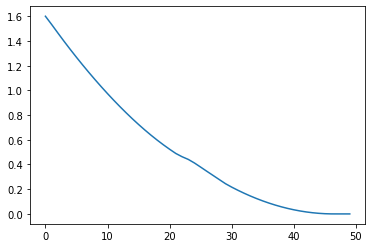

In [25]:
plt.plot(2*sol.value(e_x[0:-1])**2 + 2*sol.value(e_y[0:-1])**2 + 3000*sol.value(s)**2)

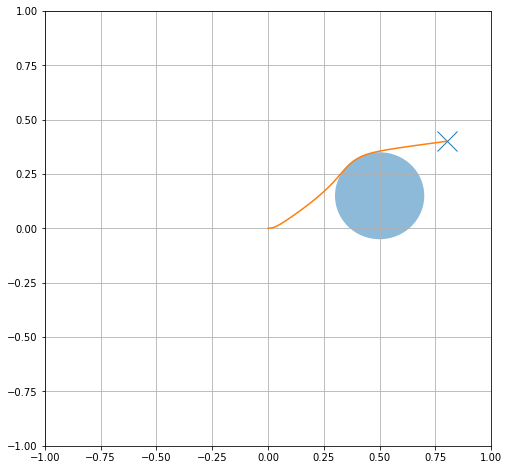

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))

c = plt.Circle((0.5, 0.15), radius=0.2, alpha=0.5)

ax.plot(0.8, 0.4, 'x', markersize=20)
ax.plot(sol_traj["x"], sol_traj["y"])
ax.add_patch(c)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

ax.grid()

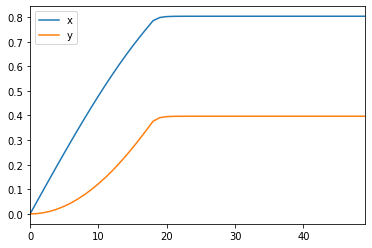

In [753]:
sol_traj[["x", "y"]].plot()

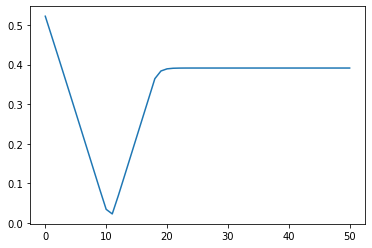

In [797]:
plt.plot(sol.value(d))

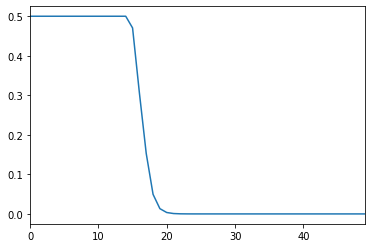

In [755]:
sol_traj["omega"].plot()

# MPC

In [942]:
OCP = opti.to_function("OCP", [x0], [U[:,0]], ["x0"], ["u"])

In [617]:
OCP([0, 0, 0])

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us (  8.13us) 121.66us (  8.11us)        15
       nlp_g  |   2.45ms (163.27us)   2.44ms (162.81us)        15
    nlp_grad  | 530.00us (530.00us) 529.69us (529.69us)         1
  nlp_grad_f  | 166.00us ( 10.38us) 165.35us ( 10.33us)        16
  nlp_hess_l  |  32.05ms (  2.29ms)  32.01ms (  2.29ms)        14
   nlp_jac_g  |  17.45ms (  1.09ms)  17.46ms (  1.09ms)        16
       total  |  71.85ms ( 71.85ms)  71.76ms ( 71.76ms)         1


DM([0.5, 0.5])

In [284]:
N_sim = 40
x_traj = np.zeros((N_sim, x.size))
u_traj = np.zeros((N_sim, u.size))

x_traj[0,:] = [0, 0, 0]
for i in range(1, N_sim):
    u_traj[i, :] = OCP(x_traj[i-1, :]).T
    
    # Simulate one sample
    x_traj[i, :] = F_RK4(x_traj[i-1,:], u_traj[i,:], 0.1).toarray().flatten()

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 520.00us (  6.05us) 529.77us (  6.16us)        86
       nlp_g  |  13.36ms (155.38us)  13.35ms (155.23us)        86
    nlp_grad  | 692.00us (692.00us) 691.87us (691.87us)         1
  nlp_grad_f  | 853.00us (  9.80us) 855.40us (  9.83us)        87
  nlp_hess_l  | 180.00ms (  2.12ms) 179.69ms (  2.11ms)        85
   nlp_jac_g  |  93.08ms (  1.07ms)  93.05ms (  1.07ms)        87
       total  | 423.91ms (423.91ms) 423.37ms (423.37ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 169.00us (  5.83us) 174.22us (  6.01us)        29
       nlp_g  |   4.41ms (151.93us)   4.40ms (151.79us)        29
    nlp_grad  | 588.00us (588.00us) 587.73us (587.73us)         1
  nlp_grad_f  | 255.00us (  9.44us) 257.83us (  9.55us)        27
  nlp_hess_l  |  52.91ms (  2.12ms)  52.82ms (  2.11ms)        25
   nlp_jac_g  |  28.71ms (  1.06ms)  28.66ms (  1.06ms)        27
       tot

    nlp_grad  | 563.00us (563.00us) 563.27us (563.27us)         1
  nlp_grad_f  | 585.00us (  9.14us) 583.56us (  9.12us)        64
  nlp_hess_l  | 130.07ms (  2.10ms) 130.01ms (  2.10ms)        62
   nlp_jac_g  |  67.39ms (  1.05ms)  67.39ms (  1.05ms)        64
       total  | 302.88ms (302.88ms) 302.62ms (302.62ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 278.00us (  5.45us) 278.24us (  5.46us)        51
       nlp_g  |   7.55ms (148.10us)   7.55ms (148.02us)        51
    nlp_grad  | 550.00us (550.00us) 549.80us (549.80us)         1
  nlp_grad_f  | 442.00us (  8.50us) 447.03us (  8.60us)        52
  nlp_hess_l  | 103.23ms (  2.06ms) 103.10ms (  2.06ms)        50
   nlp_jac_g  |  53.73ms (  1.03ms)  53.67ms (  1.03ms)        52
       total  | 237.81ms (237.81ms) 237.47ms (237.47ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 261.00us (  5.55us) 260.25us (  5.54us)        47
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 318.00us (  6.12us) 320.03us (  6.15us)        52
       nlp_g  |   8.10ms (155.85us)   8.09ms (155.57us)        52
    nlp_grad  | 582.00us (582.00us) 581.99us (581.99us)         1
  nlp_grad_f  | 496.00us (  9.36us) 494.35us (  9.33us)        53
  nlp_hess_l  | 107.84ms (  2.11ms) 107.80ms (  2.11ms)        51
   nlp_jac_g  |  56.91ms (  1.07ms)  56.88ms (  1.07ms)        53
       total  | 245.91ms (245.91ms) 245.66ms (245.66ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 291.00us (  5.71us) 292.78us (  5.74us)        51
       nlp_g  |   7.74ms (151.75us)   7.73ms (151.56us)        51
    nlp_grad  | 540.00us (540.00us) 539.55us (539.55us)         1
  nlp_grad_f  | 450.00us (  8.65us) 451.62us (  8.69us)        52
  nlp_hess_l  | 104.13ms (  2.08ms) 103.92ms (  2.08ms)        50
   nlp_jac_g  |  54.31ms (  1.04ms)  54.24ms (  1.04ms)        52
       tot

In [ ]:
plt.spy(sol.value(ca.hessian(opti.f,opti.x)[0]))

In [285]:
sim_res = pd.DataFrame(np.hstack((x_traj, u_traj)), columns=['x', 'y', 'theta', 'v', 'omega'])

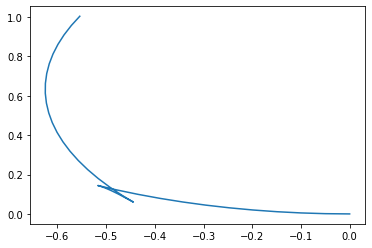

In [286]:
plt.plot(sim_res["x"], sim_res["y"])

In [ ]:
sim_res[['omega']].plot()

# Extras

In [943]:
OCP.save("ocp.casadi")

In [620]:
OCP_loaded = ca.Function.load("ocp.casadi")

In [621]:
OCP_loaded

Function(OCP:(x0[3])->(u[2]) MXFunction)

In [ ]:
OCP.generate("ocp_codegen", {"main": True})